## Compare Random Forest in the case of binary class (Sell, Buy)

In [49]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_random_forest,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 199
FPR_MAX = 0.05
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline Random Forest Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
# orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 16:57:45,491] A new study created in memory with name: no-name-21e74417-6947-4193-a91d-5138f5dcff82
[I 2024-02-14 16:57:57,506] Trial 0 finished with value: 0.6835832325074951 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 192, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6835832325074951.
[I 2024-02-14 16:58:06,672] Trial 1 finished with value: 0.6877653394878795 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 193, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.6877653394878795.
[I 2024-02-14 16:58:09,525] Trial 2 finished with value: 0.6632351210066011 and parameters: {'max_features': 'sqrt', 'max_depth': 11, 'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6877653394878795.
[I 2024-0

Number of finished trials: 71
Best trial:
  Value: 0.7056007522192915
  Params: 
    max_features: sqrt
    max_depth: 16
    n_estimators: 128
    min_samples_split: 6
    min_samples_leaf: 4
    bootstrap: False
    criterion: gini


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=16,
                                        min_samples_leaf=4, min_samples_split=6,
                                        n_estimators=128, random_state=1968))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.9704708699122107

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.46


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.5577889447236181

              precision    recall  f1-score   support

           0       0.56      0.65      0.60        98
           1       0.60      0.50      0.55       101

    accuracy                           0.58       199
   macro avg       0.58      0.58      0.58       199
weighted avg       0.58      0.58      0.58       199



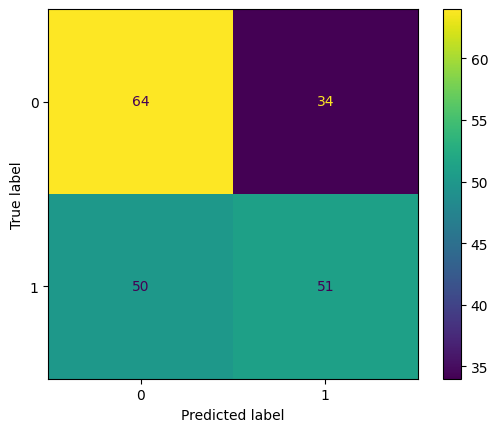

In [18]:
display_report(y_test, predictions)

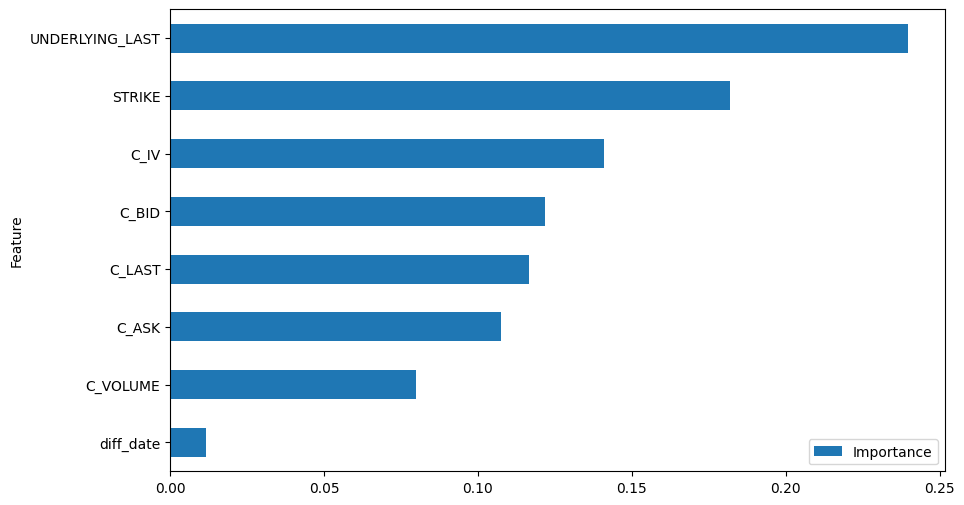

In [19]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [21]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,319.349996,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,319.349996,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,319.349996,401.389886


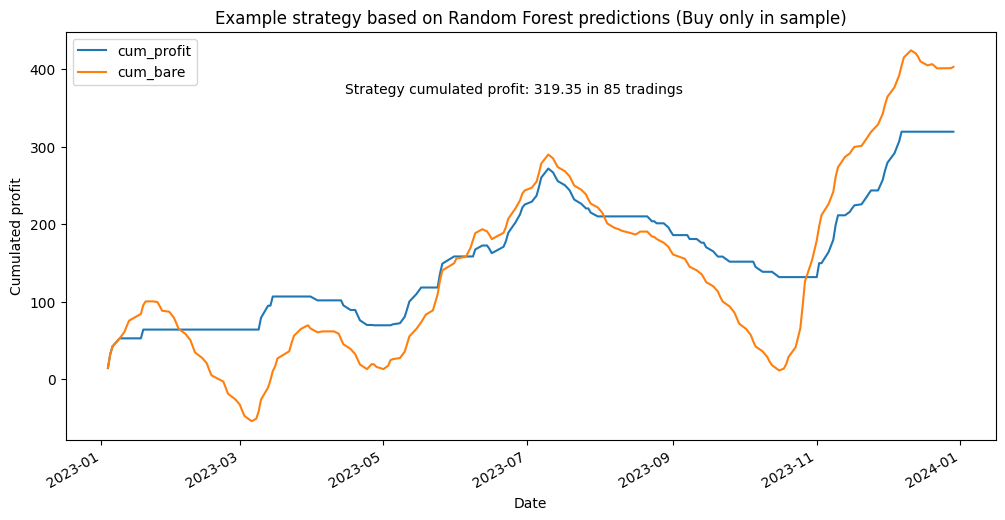

In [23]:
plot_strategy(strategy_df, "Random Forest", "(Buy only in sample)")

In [24]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## Random Forest with data from MC simulation and additional features

In [25]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [26]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [28]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2048, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_random_forest(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 17:07:52,404] A new study created in memory with name: no-name-1e823956-248a-4100-9b72-13127fb3817d
[I 2024-02-14 17:08:14,448] Trial 0 finished with value: 0.7396493052727152 and parameters: {'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 141, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7396493052727152.
[I 2024-02-14 17:08:30,113] Trial 1 finished with value: 0.7388701287249387 and parameters: {'max_features': 'sqrt', 'max_depth': 17, 'n_estimators': 148, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7396493052727152.
[I 2024-02-14 17:08:38,772] Trial 2 finished with value: 0.7324342000895878 and parameters: {'max_features': 'sqrt', 'max_depth': 13, 'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.7396493052727152

Number of finished trials: 65
Best trial:
  Value: 0.7612884664104083
  Params: 
    max_features: log2
    max_depth: 17
    n_estimators: 176
    min_samples_split: 10
    min_samples_leaf: 2
    bootstrap: False
    criterion: gini


In [29]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**study.best_params, random_state=1968)),
    ]
)

In [30]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=17,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=176,
                                        random_state=1968))])

In [31]:
# In-sample score
pipe.score(X_train, y_train)

0.9968076616121309

In [32]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.43


In [33]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [34]:
pipe.score(X_test, y_test)

0.5829145728643216

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        98
           1       0.59      0.56      0.58       101

    accuracy                           0.58       199
   macro avg       0.58      0.58      0.58       199
weighted avg       0.58      0.58      0.58       199



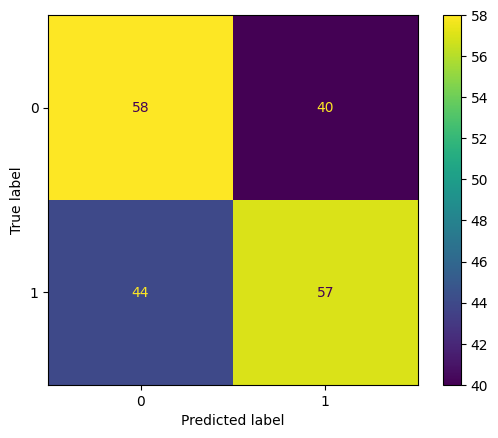

In [35]:
display_report(y_test, predictions)

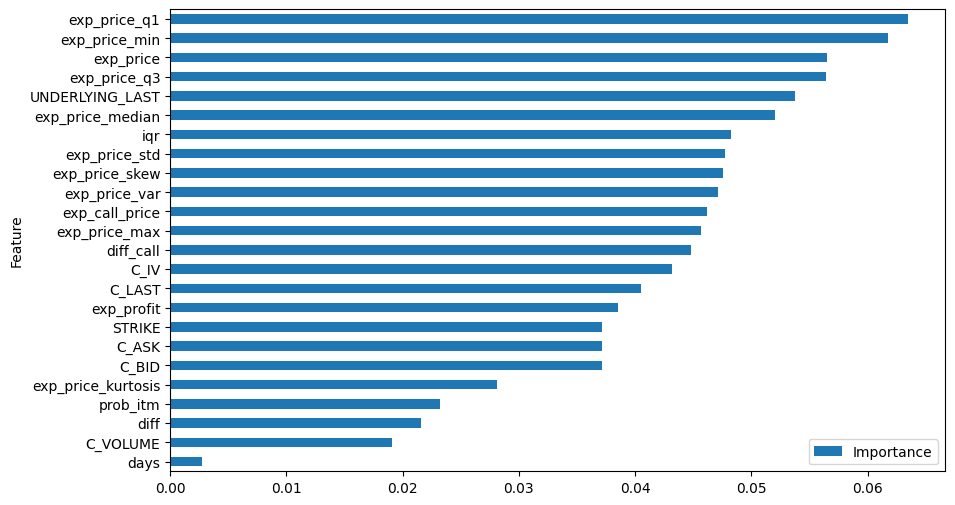

In [36]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [37]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [38]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [39]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,342.859948,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,342.859948,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,342.859948,401.389886


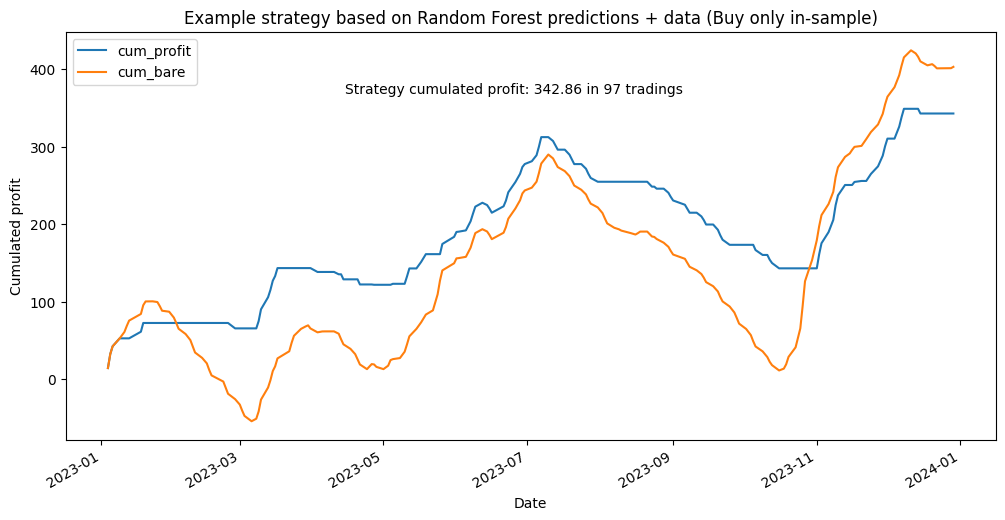

In [40]:
plot_strategy(strategy_df, "Random Forest", "+ data (Buy only in-sample)")

In [41]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [42]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)

In [43]:
compare_df[mask_in]

,bare_rf_pred_in,cum_profit_out,mmar_rf_pred_in,mmar_cum_profit_out,mmar_cum_bare_out
7,0,52.579971,1,61.119979,84.049998
29,0,63.889979,1,65.449988,-25.909938
35,0,63.889979,1,74.840002,-41.749908
38,0,94.730009,1,115.070034,-1.519877
40,0,106.600011,1,132.980039,16.390128
41,0,106.600011,1,143.280042,26.690131
53,0,101.620016,1,135.280051,58.570128
56,1,89.220021,0,128.760056,38.990133
58,1,82.510021,0,128.760056,25.480133
60,1,69.860021,0,122.150056,12.830133


In [44]:
compare_df[mask_in].shape

(44, 5)

In [45]:
compare_df.sum(axis=0)

bare_rf_pred_in           85.000000
cum_profit_out         30981.181600
mmar_rf_pred_in           97.000000
mmar_cum_profit_out    36913.349375
mmar_cum_bare_out      28399.674850
dtype: float64

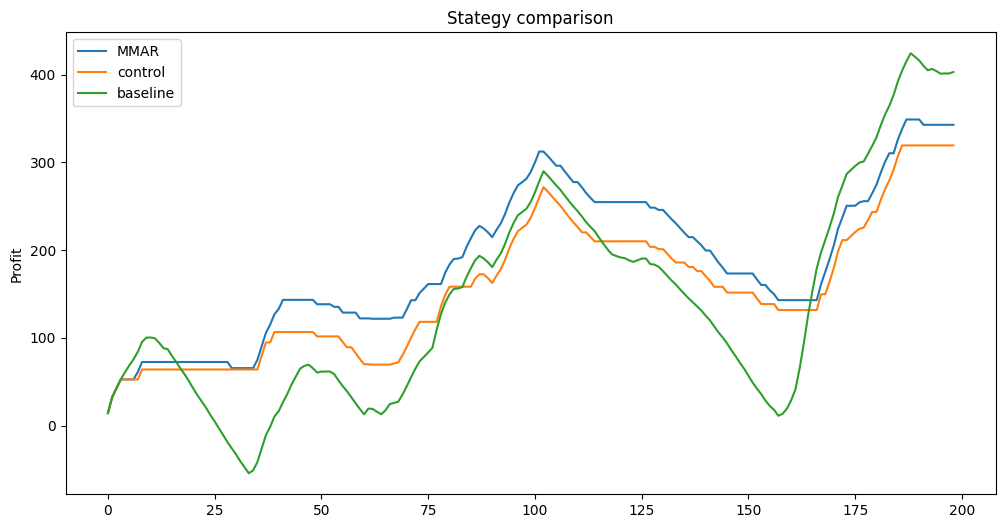

In [50]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()